In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.1 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer
from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization

In [ ]:
data = pd.read_csv("Dataset.csv")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
tokens = []
for text in data["Generation"]:
  tokens.append(tokenizer.tokenize(text))

In [ ]:
token_ids = []
for token in tokens:
  token_ids.append(tokenizer.convert_tokens_to_ids(token))

In [ ]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Tokenize the text into words and sentences
feature = []
for corpus in data["Generation"]:
  words = word_tokenize(corpus)
  sentences = sent_tokenize(corpus)
  word_lengths = [len(w) for w in words if w not in stopwords.words('english')]
  avg_word_length = sum(word_lengths) / len(word_lengths)
  avg_sentence_length = len(words) / len(sentences)
  vocab = set(words)
  vocab_size = len(vocab)
  lexical_diversity = len(words) / vocab_size
  pos_tags = nltk.pos_tag(words)
  noun_count = len([w for w, pos in pos_tags if pos.startswith('NN')])
  verb_count = len([w for w, pos in pos_tags if pos.startswith('VB')])
  adj_count = len([w for w, pos in pos_tags if pos.startswith('JJ')])
  feature.append([avg_word_length, avg_sentence_length, vocab_size, lexical_diversity, noun_count, verb_count, adj_count])

In [ ]:
maxlen = 100
padded_sequences = pad_sequences(token_ids, maxlen=maxlen)

In [ ]:
feat = np.array(feature)

In [ ]:
padd = np.concatenate([padded_sequences, feat], axis = 1)

In [ ]:
labels = pd.get_dummies(data["label"]).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padd, labels, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Embedding(tokenizer.vocab_size + 8, 128, input_length=maxlen + 7))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(11, activation="softmax"))


# compile and train the model
batch_size = 64
epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
118/118 [==============================] - 44s 250ms/step - loss: 1.2802 - accuracy: 0.5396 - val_loss: 1.8434 - val_accuracy: 0.5085
Epoch 2/30
118/118 [==============================] - 19s 163ms/step - loss: 0.6517 - accuracy: 0.7439 - val_loss: 1.2098 - val_accuracy: 0.6706
Epoch 3/30
118/118 [==============================] - 19s 158ms/step - loss: 0.4104 - accuracy: 0.8474 - val_loss: 0.7987 - val_accuracy: 0.7239
Epoch 4/30
118/118 [==============================] - 16s 132ms/step - loss: 0.2508 - accuracy: 0.9159 - val_loss: 0.6138 - val_accuracy: 0.7745
Epoch 5/30
118/118 [==============================] - 12s 105ms/step - loss: 0.1606 - accuracy: 0.9504 - val_loss: 0.5638 - val_accuracy: 0.7894
Epoch 6/30
118/118 [==============================] - 13s 107ms/step - loss: 0.1023 - accuracy: 0.9705 - val_loss: 0.6414 - val_accuracy: 0.7724
Epoch 7/30
118/118 [==============================] - 10s 81ms/step - loss: 0.0967 - accuracy: 0.9721 - val_loss: 0.8097 - val_acc

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

74/74 [==============================] - 3s 14ms/step


In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       206
           1       0.71      0.58      0.64       215
           2       0.91      1.00      0.95       211
           3       0.76      0.62      0.68       214
           4       0.74      0.76      0.75       217
           5       0.47      0.51      0.49       209
           6       0.65      0.78      0.71       213
           7       0.75      0.75      0.75       217
           8       0.80      0.77      0.79       220
           9       0.97      1.00      0.98       202
          10       0.99      0.93      0.96       222

    accuracy                           0.79      2346
   macro avg       0.79      0.79      0.79      2346
weighted avg       0.79      0.79      0.79      2346

[[204   0   1   0   0   0   0   0   0   0   1]
 [  3 124   2  19   0  46   7   0  12   0   2]
 [  0   0 211   0   0   0   0   0   0   0   0]
 [  2  29   0 132   1  19   9   0  22   0   0]

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_macro = f1_score(y_test, y_pred, average="macro")

print("F1 macro score:", f1_macro)

F1 macro score: 0.7875198427885941


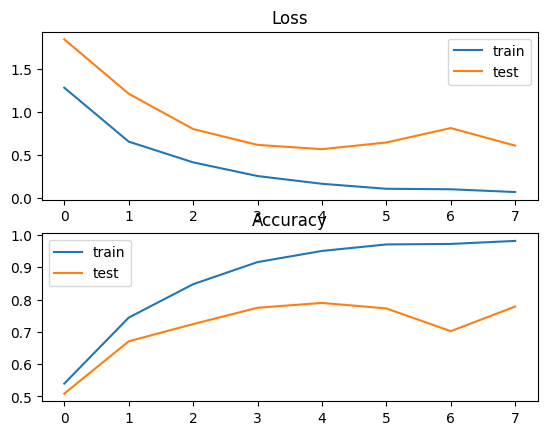

In [ ]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()